## Libraries

In [1]:
from andi_datasets.utils_challenge import *
from andi_datasets.utils_trajectories import TAMSD, get_D,
from andi_datasets.analysis_methods import get_changepoints_convexhull
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm


In [19]:
def df_to_txt(trues_raw_df, file = None):
    trues_df = pd.DataFrame(columns = ['traj_idx', 'changepoints', 'alphas', 'Ds', 'states', 'T'])

    file_gt = []
    for idx in tqdm(trues_raw_df['idx'].unique()):
        ds_traj = trues_raw_df.loc[trues_raw_df['idx'] == idx]['D'].values
        alphas_traj = trues_raw_df.loc[trues_raw_df['idx'] == idx]['alpha'].values

        merge = np.hstack((alphas_traj.reshape(ds_traj.shape[0], 1), ds_traj.reshape(ds_traj.shape[0], 1)))

        CP, alphas, Ds = continuous_label_to_list(merge)
        states = np.ones_like(alphas)*3

        list_gt = [idx, Ds[0], alphas[0], states[0]]
        for gtc, gta, gtd, gts in zip(CP, alphas[1:], Ds[1:], states[1:]):
            list_gt += [gtc, gtd, gta, gts]

    #     file_gt.append(list_gt)
        if file is not None:
            with open(file, 'a') as f:
                writer = csv.writer(f, delimiter=',', lineterminator='\n',)
                writer.writerow(list_gt)

        current_row = trues_df.shape[0]
        for param, pred_param in zip(trues_df.columns, [current_row, CP, alphas, Ds, states, len(ds_traj)]):
            trues_df.loc[current_row, param] = pred_param
            
    return trues_df

In [38]:
idx = 6; df_true = df_true4; df_pred = df_pred4

def list_to_continuous(df_pred, df_true, idx):

    t = df_true.loc[idx]['T']
    
    cps = df_pred.loc[idx]['changepoints']
    cps = [0]+cps+[t]   
    alphas = df_pred.loc[idx]['alphas']
    Ds = df_pred.loc[idx]['Ds']
    a = np.zeros(t); d = np.zeros(t);
    for idx, cp in enumerate(cps[:-1]):
        a[int(cp):int(cps[idx+1])] = alphas[idx]
        d[int(cp):int(cps[idx+1])] = Ds[idx]
        
    cps_t = df_pred.loc[idx]['changepoints']
    cps_t = [0]+cps_t+[t]   
    alphas_t = df_true.loc[idx]['alphas']
    Ds_t = df_true.loc[idx]['Ds']
    a_t = np.zeros(t); d_t = np.zeros(t);
    for idx, cp in enumerate(cps[:-1]):
        a[int(cp):int(cps[idx+1])] = alphas[idx]
        d[int(cp):int(cps[idx+1])] = Ds[idx]

## Check on the segments + tmsd to see effect of alpha and D

In [35]:
trajs_cond2 = pd.read_csv('trues/condition_2.csv')
Ds = []
for idx in tqdm(trues_raw_df['idx'].unique()):
    traj = trajs_cond2.loc[trajs_cond2['idx'] == idx]['x'].values
    Ds.append(get_D(traj, [2,3,4]))
Ds = np.array(Ds)

  0%|          | 0/4562 [00:00<?, ?it/s]

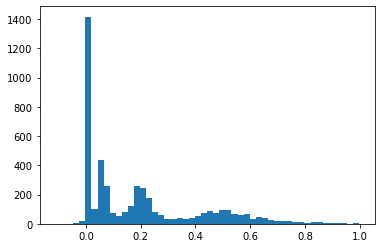

In [38]:
plt.hist(Ds[Ds <1], bins = 50);

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

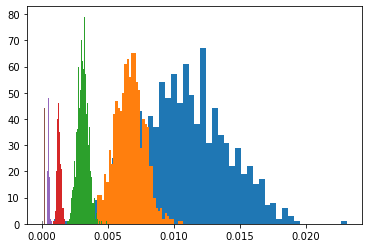

In [24]:
from stochastic.processes.noise import FractionalGaussianNoise as FGN

alpha = 1; T = 1000; 
for alpha in np.arange(0.2, 1.8, 0.2):
    Ds = []
    for _ in tqdm(range(1000)):
        disp = FGN(hurst = alpha/2).sample(n = T)
        Ds.append(get_D(np.cumsum(disp), [2,3,4]))
    # disp = np.sqrt(2*D)*(disp/np.std(disp))
    Ds = np.array(Ds)
    plt.hist(Ds, bins = 50)


# Condition 1: 2-state diffusion

2 state diffusion 
Three state problem with properties:
- $\alpha = [0.5, 1.5]$
- $D_1 = [1, 0.1]\cdot D$
- $M = \begin{pmatrix} 0.98 & 0.02 \\   0.02 & 0.98 \end{pmatrix}$

In [40]:
trues_raw_df = pd.read_csv('trues/labels_condition_1.csv')
df_true_1 = df_to_txt(trues_raw_df)

  0%|          | 0/4562 [00:00<?, ?it/s]

## Carlo's U-track ...

In [4]:
pred_path = '../testing/preds/0217_carlo_condition_1.txt'
df_pred = load_file_to_df(pred_path)

In [5]:
rmse_CP, JI, error_alpha, error_D, error_s = error_ensemble_prediction(df_pred, df_true, prints = True)

  0%|          | 0/4562 [00:00<?, ?it/s]

Summary of the experiment: 

Number of states: 2 
Exponents: [0.5 1.5] 
Diffusion Coeff.: [0.01 0.1 ] 

Changepoint Metrics 
RMSE: 4.975 
Jaccard Index: 0.252 

Diffusion property metrics 
Error anomalous exponent: 0.3717857700058506 
Error diffusion coefficient: 0.484506207328505 
Error diffusive state: 0.058116102190730025


In [21]:
Ds = np.concatenate(df_pred['Ds'].values)
alphas = np.concatenate(df_pred['alphas'].values)

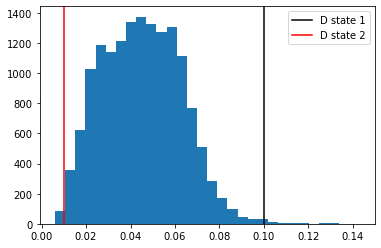

In [28]:
plt.hist(Ds[Ds < 0.2], bins = 30)
plt.axvline(true_D[0], label = 'D state 1', c = 'k')
plt.axvline(true_D[1], label = 'D state 2', c = 'r')
plt.legend()

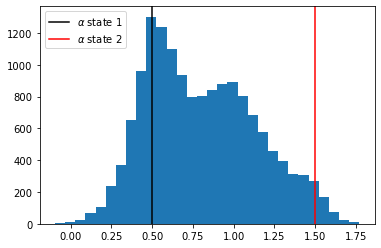

In [24]:
plt.hist(alphas, bins = 30)
plt.axvline(true_a[0], label = r'$\alpha$ state 1', c = 'k')
plt.axvline(true_a[1], label = r'$\alpha$ state 2', c = 'r')
plt.legend()

## HMM 

In [47]:
df_hmm1 = pd.read_csv('preds/condition_1_StateHMM.csv', names = ['t', 'idx', 'state'])

In [56]:
CPs_hmm1 = []
for idx in tqdm(df_hmm1['idx'].unique()):
    pred = df_hmm1.loc[df_hmm1['idx'] == idx]['state'].values
    CP = np.argwhere(pred[1:] != pred[:-1])+1
    CPs_hmm1.append(CP)

  0%|          | 0/4562 [00:00<?, ?it/s]

In [57]:
ensemble_changepoint_error(df_true_1['changepoints'].values, CPs_hmm, threshold = 10)

(3.129910131769324, 0.6543643196483018)

## Convex hull

In [37]:
df = pd.read_csv('trues/condition_1.csv')
indices = df['idx'].unique()
trajs = []
CPs_CH = []
for idx in tqdm(indices):
    traj = np.vstack((df.loc[df['idx'] == idx]['x'].values,
                      df.loc[df['idx'] == idx]['y'].values)).transpose()
    
    CPs_CH.append(get_changepoints_convexhull([traj])[0].flatten())
    

  0%|          | 0/4562 [00:00<?, ?it/s]

c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysi

In [38]:
ensemble_changepoint_error(df_true_1['changepoints'], CPs_CH, threshold = 10)

(4.6320383499989, 0.5551452364429463)

# Condition 2: single state

Three populations, with same $D$ and three $\alpha = [0.5, 1, 1.5]$

In [58]:
trues_raw_df = pd.read_csv('trues/labels_condition_2.csv')
df_true2 = df_to_txt(trues_raw_df)


  0%|          | 0/3181 [00:00<?, ?it/s]

## Carlo's predictions

In [59]:
pred_path2 = '../testing/preds/0217_carlo_condition_2.txt'
df_pred2 = load_file_to_df(pred_path2)

In [60]:
rmse_CP, JI, error_alpha, error_D, error_s = error_ensemble_prediction(df_pred2, df_true2)

  0%|          | 0/3181 [00:00<?, ?it/s]

10
Summary of the experiment: 

Number of states: 3 
Exponents: [0.5 1.  1.5] 
Diffusion Coeff.: [0.1] 

Changepoint Metrics 
RMSE: 10 
Jaccard Index: 0 

Diffusion property metrics 
Error anomalous exponent: 0.12505809493869852 
Error diffusion coefficient: 0.0024886121820169877 
Error diffusive state: 0.2370323797547941


c:\users\gorka\github\andi_datasets_dev\andi_datasets\utils_challenge.py:274: UserWarning: No segments found in this dataset.
  warnings.warn(wrn_str)


In [51]:
true_D = [0.1]; true_a = [0.5, 1, 1.5]
Ds = np.concatenate(df_pred2['Ds'].values)
alphas = np.concatenate(df_pred2['alphas'].values)

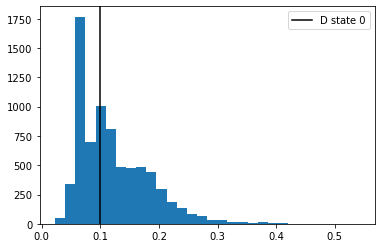

In [52]:
plt.hist(Ds, bins = 30)
for idx, true in enumerate(true_D):
    plt.axvline(true, label = f'D state {idx}', c = 'k')
plt.legend()

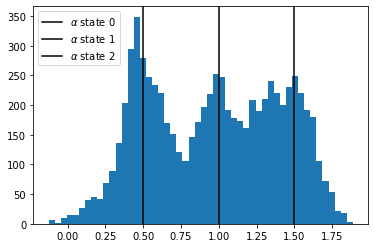

In [49]:
plt.hist(alphas, bins = 50)
for idx, true in enumerate(true_a):
    plt.axvline(true, label = fr'$\alpha$ state {idx}', c = 'k')
plt.legend()

## HMM prediction

In [62]:
df_hmm2 = pd.read_csv('preds/condition_2_StateHMM.csv', names = ['t', 'idx', 'state'])

In [82]:
CPs_hmm2 = []
lens = []
for idx in tqdm(df_hmm2['idx'].unique()):
    pred = df_hmm2.loc[df_hmm2['idx'] == idx]['state'].values
    CP = np.argwhere(pred[1:] != pred[:-1])+1
    CPs_hmm2.append(CP.flatten())
    lens.append(len(pred))

  0%|          | 0/3181 [00:00<?, ?it/s]

In [83]:
CPs_hmm2

[array([2], dtype=int64),
 array([207, 212], dtype=int64),
 array([2], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([4], dtype=int64),
 array([], dtype=int64),
 array([2], dtype=int64),
 array([161, 162], dtype=int64),
 array([], dtype=int64),
 array([3], dtype=int64),
 array([3], dtype=int64),
 array([], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([1], dtype=int64),
 array([], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([], dtype=int64),
 array([2], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([2], dtype=int64),
 array([], dtype=int64),
 array([2], dtype=int64),
 array([2], dtype=int64),
 array([], dtype=int64),
 array([], dtype

## Convex hull

In [102]:
df = pd.read_csv('trues/condition_2.csv')
indices = df['idx'].unique()

CPs_CH2 = []
for idx in tqdm(indices):
    traj = np.vstack((df.loc[df['idx'] == idx]['x'].values,
                      df.loc[df['idx'] == idx]['y'].values)).transpose()
    
    CPs_CH2.append(get_changepoints_convexhull([traj])[0].flatten())
    

  0%|          | 0/3181 [00:00<?, ?it/s]

c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysi

# Condition 3: Compartments
Two diffusive state with properties:
- $\alpha = 0.7$
- $D = [0.1, 1]$
- transmittance $T = 0.1$

In [85]:
trues_raw_df = pd.read_csv('trues/labels_condition_3.csv')
df_true3 = df_to_txt(trues_raw_df)

  0%|          | 0/6105 [00:00<?, ?it/s]

## Carlo

In [92]:
pred_path3 = '../testing/preds/0217_carlo_condition_3.txt'
df_pred3 = load_file_to_df(pred_path3)

In [93]:
rmse_CP, JI, error_alpha, error_D, error_s = error_ensemble_prediction(df_pred3, df_true3)

# df = pd.DataFrame(columns = ['RMSE CP', 'Jaccard Index', r'MAE $\alpha$', r'log_error D', 'F1 score states'])
# df.loc[0] = rmse_CP, JI, error_alpha, error_D, error_s
# df

  0%|          | 0/6105 [00:00<?, ?it/s]

Summary of the experiment: 

Number of states: 1 
Exponents: [0.7] 
Diffusion Coeff.: [0.1 1. ] 

Changepoint Metrics 
RMSE: 5.422 
Jaccard Index: 0.204 

Diffusion property metrics 
Error anomalous exponent: 0.14599666592078764 
Error diffusion coefficient: 0.48193594128441775 
Error diffusive state: 0.0003356455582904453


In [58]:
Ds = np.concatenate(df_pred3['Ds'].values)
alphas = np.concatenate(df_pred3['alphas'].values)
true_D = [0.1, 1]
true_a = [0.7]

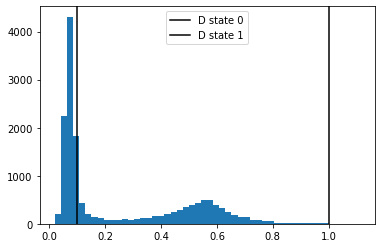

In [59]:
plt.hist(Ds, bins = 50)
for idx, true in enumerate(true_D):
    plt.axvline(true, label = f'D state {idx}', c = 'k')
plt.legend()

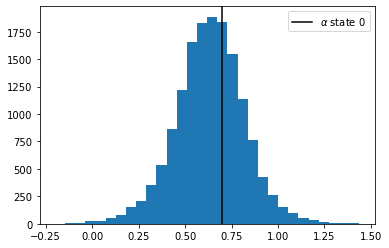

In [20]:
plt.hist(alphas, bins = 30)
for idx, true in enumerate(true_a):
    plt.axvline(true, label = fr'$\alpha$ state {idx}', c = 'k')
plt.legend()

## HMM prediction

In [87]:
df_hmm3 = pd.read_csv('preds/condition_3_StateHMM.csv', names = ['t', 'idx', 'state'])

In [113]:
CPs_hmm3 = []
lens = []
for idx in tqdm(df_hmm3['idx'].unique()):
    pred = df_hmm3.loc[df_hmm3['idx'] == idx]['state'].values
    CP = np.argwhere(pred[1:] != pred[:-1])+1
    CPs_hmm3.append(CP.flatten())
    lens.append(len(pred))

  0%|          | 0/6105 [00:00<?, ?it/s]

In [100]:
ensemble_changepoint_error(df_true3['changepoints'].values, CPs_hmm3, threshold = 10)

(1.998006657267801, 0.8575724439584472)

## Convex hull

In [103]:
df = pd.read_csv('trues/condition_3.csv')
indices = df['idx'].unique()

CPs_CH3 = []
for idx in tqdm(indices):
    traj = np.vstack((df.loc[df['idx'] == idx]['x'].values,
                      df.loc[df['idx'] == idx]['y'].values)).transpose()
    
    CPs_CH3.append(get_changepoints_convexhull([traj])[0].flatten())
    

  0%|          | 0/6105 [00:00<?, ?it/s]

c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysi

In [111]:
ensemble_changepoint_error(df_true3['changepoints'], CPs_CH3, threshold = 10)

(6.571732782966045, 0.4514356611130805)

# Condition 4: Trapping

- $\alpha = 0.8$
- $D =2*D$ (non-trapped diffusion)
- Trap density $= 0.8$.
- $P_b = 1$; $P_u=0.05$

In [90]:
trues_raw_df = pd.read_csv('trues/labels_condition_4.csv')
df_true4 = df_to_txt(trues_raw_df)

  0%|          | 0/1080 [00:00<?, ?it/s]

## Carlo

In [94]:
pred_path4 = '../testing/preds/0217_carlo_condition_4.txt'
df_pred4 = load_file_to_df(pred_path4)

In [95]:
rmse_CP, JI, error_alpha, error_D, error_s = error_ensemble_prediction(df_pred4, df_true4)


  0%|          | 0/1080 [00:00<?, ?it/s]

Summary of the experiment: 

Number of states: 2 
Exponents: [0.  0.8] 
Diffusion Coeff.: [0.  0.2] 

Changepoint Metrics 
RMSE: 5.255 
Jaccard Index: 0.524 

Diffusion property metrics 
Error anomalous exponent: 0.38387262411347517 
Error diffusion coefficient: 4.058455711672142 
Error diffusive state: 0.00047281323877068556


In [44]:
Ds = np.concatenate(df_pred4['Ds'].values)
alphas = np.concatenate(df_pred4['alphas'].values)
true_D = [0, 0.2]
true_a = [0.8]

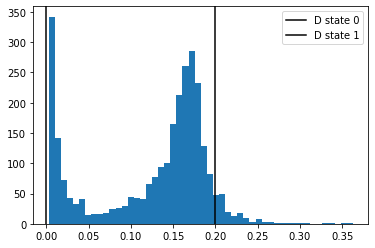

In [45]:
plt.hist(Ds[Ds < 0.5], bins = 50)
for idx, true in enumerate(true_D):
    plt.axvline(true, label = f'D state {idx}', c = 'k')
plt.legend()

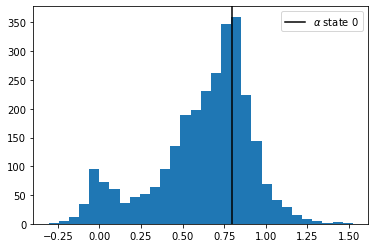

In [46]:
plt.hist(alphas, bins = 30)
for idx, true in enumerate(true_a):
    plt.axvline(true, label = fr'$\alpha$ state {idx}', c = 'k')
plt.legend()

## HMM

In [97]:
df_hmm4 = pd.read_csv('preds/condition_4_StateHMM.csv', names = ['t', 'idx', 'state'])

In [98]:
CPs_hmm4 = []
lens = []
for idx in tqdm(df_hmm4['idx'].unique()):
    pred = df_hmm4.loc[df_hmm4['idx'] == idx]['state'].values
    CP = np.argwhere(pred[1:] != pred[:-1])+1
    CPs_hmm4.append(CP.flatten())

  0%|          | 0/1080 [00:00<?, ?it/s]

In [101]:
ensemble_changepoint_error(df_true4['changepoints'].values, CPs_hmm4, threshold = 10)

(2.1775824920680704, 0.7059724349157733)

## Convex hull

In [104]:
df = pd.read_csv('trues/condition_4.csv')
indices = df['idx'].unique()

CPs_CH4 = []
for idx in tqdm(indices):
    traj = np.vstack((df.loc[df['idx'] == idx]['x'].values,
                      df.loc[df['idx'] == idx]['y'].values)).transpose()
    
    CPs_CH4.append(get_changepoints_convexhull([traj])[0].flatten())
    

  0%|          | 0/1080 [00:00<?, ?it/s]

c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysis_methods.py:20: RuntimeWarning: Mean of empty slice.
  below_mean = Sd < Sd.mean()
C:\Users\Gorka\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\gorka\github\andi_datasets_dev\andi_datasets\analysi

In [108]:
ensemble_changepoint_error(df_true4['changepoints'], CPs_CH4, threshold = 10)

(4.861907478541411, 0.3809897879025923)